In [1]:
import ast
import json
import os
import shutil

import albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import tensorflow_addons as tfa
import torch
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import re
from itertools import chain

from pydicom.pixel_data_handlers.util import apply_voi_lut

In [16]:
class Test:
    def crop(img, model):
        img_224 = tf.image.resize(
            img,
            (224, 224),
        )
        img_224 = tf.cast(img_224, tf.uint8)
        img_224 = tf.expand_dims(img_224, axis=0)
        coord = model.predict(img_224)[0]
        xmin = coord[0] * img.shape[1]
        ymin = coord[1] * img.shape[0]
        xmax = coord[2] * img.shape[1]
        ymax = coord[3] * img.shape[0]
        return xmin, ymin, xmax, ymax

    def prepare_data(
        data_path, path_to_save, train_mode=True, n_train_sample=10, jpg=True, crop_model_path=None
    ):
        if crop_model_path is not None:
            crop_model = keras.models.load_model(crop_model_path)
        if not os.path.exists(path_to_save):
            os.mkdir(path_to_save)
        test_df = pd.DataFrame()
        if train_mode:
            p = os.listdir(data_path)[:n_train_sample]
        else:
            p = os.listdir(data_path)
        for folder1 in tqdm(p):
            for folder2 in os.listdir(data_path + folder1):
                path = os.path.join(data_path, folder1, folder2)
                for img_file in os.listdir(path):
                    img_path = os.path.join(path, img_file)
                    test_df.loc[img_file, "path"] = img_path
                    data_file = dicom.dcmread(img_path)
                    test_df.loc[img_file, "StudyInstanceUID"] = folder1
                    test_df.loc[img_file, "image"] = img_file[:-4]
                    test_df.loc[img_file, "modality"] = data_file.Modality
                    test_df.loc[img_file, "PatientSex"] = data_file.PatientSex
                    test_df.loc[
                        img_file, "BodyPartExamined"
                    ] = data_file.BodyPartExamined
                    test_df.loc[
                        img_file, "PhotometricInterpretation"
                    ] = data_file.PhotometricInterpretation
                    test_df.loc[img_file, "width"] = data_file.pixel_array.shape[1]
                    test_df.loc[img_file, "height"] = data_file.pixel_array.shape[0]
                    img = data_file.pixel_array
                    if data_file.PhotometricInterpretation == "MONOCHROME1":
                        img = img.max() - img
                    img = (img - img.min()) / (img.max() - img.min())
                    img = (np.array(img) * 255).astype("uint8")
                    img = np.stack([img, img, img], axis=-1)
                    if crop_model_path is not None:
                        xmin, ymin, xmax, ymax = Test.crop(img, crop_model)
                        test_df.loc[img_file, "xmin"] = xmin
                        test_df.loc[img_file, "ymin"] = ymin
                        test_df.loc[img_file, "xmax"] = xmax
                        test_df.loc[img_file, "ymax"] = ymax
                    img = Image.fromarray(img)
                    if jpg:
                        img.save(path_to_save + img_file[:-4] + ".jpg", format="JPEG")
                    else:
                        img.save(path_to_save + img_file[:-4] + ".png", format="PNG")
        test_df = test_df.reset_index(drop=True)
        test_df["path"] = test_df["path"].str.replace("\../", "/kaggle/")
        return test_df

    def make_classification(
        test_df_,
        model_path,
        generator,
        max_value = True
    ):
        pred_df = pd.DataFrame(columns=["image","negative", "typical", "indeterminate", "atypical", 'model'])
        labels = ["negative", "typical", "indeterminate", "atypical"]
        eff_models = []
        for m_path in model_path:
            if ".h5" in m_path:
                eff_models.append(keras.models.load_model(m_path))
            else:
                for file in os.listdir(m_path):
                    if ".h5" in file:
                        eff_models.append(keras.models.load_model(m_path + file))
        pred = [model.predict(generator) for model in eff_models]
        pred_mean = np.mean(pred, axis=0)
        for i in range(len(eff_models)):
            for j in range(len(pred[i])):
                img_name = test_df.loc[j, 'image']
                pred_df = pred_df.append({"image":img_name,"negative":pred[i][j][0], "typical":pred[i][j][1], "indeterminate":pred[i][j][2], "atypical":pred[i][j][3], 'model':i}, ignore_index=True)
        test_df_[["negative", "typical", "indeterminate", "atypical"]] = pred_mean
        return test_df_, pred_df

    def make_bbox_df(
        test_df_,
        SAVE_BBOX_PATH,
        bigger_better=True,
        neg_4cl=False,
        conf_1=False,
    ):
        sub_image = pd.DataFrame(columns=["id", "PredictionString"])
        if os.path.exists(SAVE_BBOX_PATH + "labels/"):
            SAVE_BBOX_PATH = SAVE_BBOX_PATH + "labels/"
        else:
            SAVE_BBOX_PATH = SAVE_BBOX_PATH
        for file in os.listdir(SAVE_BBOX_PATH):
            if ".txt" in file:
                img_name = file[:-4]
                w = test_df_[test_df_["image"] == img_name]["width"].values[0]
                h = test_df_[test_df_["image"] == img_name]["height"].values[0]
                with open(SAVE_BBOX_PATH + file, "r") as f:
                    ls = f.read()
                    ls = re.sub(r"[\n]", " ", ls).strip().split()
                    ls = list(map(float, ls))
                    list_pred = []
                    for i in range(0, len(ls), 6):
                        x_c = ls[i + 1]
                        y_c = ls[i + 2]
                        w_p = ls[i + 3]
                        h_p = ls[i + 4]
                        conf = ls[i + 5]
                        xmin = int((x_c - w_p / 2) * w)
                        ymin = int((y_c - h_p / 2) * h)
                        xmax = int((x_c + w_p / 2) * w)
                        ymax = int((y_c + h_p / 2) * h)
                        list_pred.extend(["opacity", conf, xmin, ymin, xmax, ymax])
                    sub_image = sub_image.append(
                        {
                            "id": img_name + "_image",
                            "PredictionString": " ".join(list(map(str, list_pred))),
                        },
                        ignore_index=True,
                    )
        for img_name in test_df_.image.tolist():
            if img_name + "_image" not in sub_image.id.tolist():
                if conf_1:
                    sub_image = sub_image.append(
                        {
                            "id": img_name + "_image",
                            "PredictionString": "none 1 0 0 1 1",
                        },
                        ignore_index=True,
                    )
                else:
                    if "negative_2cl" in test_df_.columns:
                        negative_2cl = test_df_[test_df_["image"] == img_name][
                            "negative_2cl"
                        ].values[0]
                    else:
                        negative_2cl = test_df_[test_df_["image"] == img_name][
                            "negative"
                        ].values[0]
                    negative = test_df_[test_df_["image"] == img_name][
                        "negative"
                    ].values[0]
                    if neg_4cl:
                        conf = negative
                    if bigger_better:
                        conf = np.max([negative_2cl, negative])
                    else:
                        conf = negative_2cl

                    sub_image = sub_image.append(
                        {
                            "id": img_name + "_image",
                            "PredictionString": "none " + str(conf) + " 0 0 1 1",
                        },
                        ignore_index=True,
                    )
        return sub_image


class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        img_size,
        batch_size=1,
        norm=False,
        crop = True
    ):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.norm = norm
        self.crop = crop

    def __len__(self):
        return self.df.shape[0] // self.batch_size

    def img_from_dicom(self, img_path, img_type, coord):
        data_file = dicom.dcmread(img_path)
        img = data_file.pixel_array
        if img_type == "MONOCHROME1":
            img = img.max() - img
        img = (img - img.min()) / (img.max() - img.min())
        img = (np.array(img) * 255).astype("uint8")
        if self.crop:
            xmin, ymin, xmax, ymax = coord
            img = img[int(ymin) : int(ymax), int(xmin) : int(xmax)]
        img = np.stack([img, img, img], axis=-1)
        img = tf.image.resize(
            img,
            (self.img_size, self.img_size),
        )
        if self.norm:
            img = tf.cast(img, tf.float32) / 255.0
        else:
            img = tf.cast(img, tf.uint8)
        return img.numpy()

    def _get_one(self, ix):
        img_name = self.df.loc[ix, "image"]
        img_path = self.df.loc[ix, "path"]
        modality = self.df.loc[ix, "modality"]
        img_type = self.df.loc[ix, "PhotometricInterpretation"]
        if self.crop:
            coord = self.df.loc[ix, ['xmin', 'ymin', 'xmax', 'ymax']].values
        else:
            coord = None
        img = self.img_from_dicom(img_path, img_type, coord)
        x = img
        return x

    def __getitem__(self, batch_ix):
        x_ = []
        for i in range(self.batch_size):
            xx = self._get_one(i + self.batch_size * batch_ix)
            x_.append(xx)
        x = np.array(x_)
        return x

In [8]:
test_df = Test.prepare_data(
    data_path="/app/_data/test/",
    path_to_save="/app/_data/tmp/",
    train_mode=True,
    jpg=True,
    crop_model_path = '/app/_data/models/CropBest/EffB0_3.h5'
)

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]
<ipython-input-7-238ae3d2a04e>:65: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df["path"] = test_df["path"].str.replace("\../", "/kaggle/")


In [9]:
test_df

,path,StudyInstanceUID,image,modality,PatientSex,BodyPartExamined,PhotometricInterpretation,width,height,xmin,ymin,xmax,ymax
0,/app/_data/test/fe64182ae21d/d56579abcb25/a82c...,fe64182ae21d,a82ca8f37fb6,CR,F,CHEST,MONOCHROME2,4248.0,3480.0,696.590995,415.931989,3249.970861,2350.553234
1,/app/_data/test/6117058c3931/d51d2a5e7f7a/b74f...,6117058c3931,b74f81d65e79,DX,M,CHEST,MONOCHROME2,3032.0,3032.0,254.029222,449.704807,2591.709461,2582.702674
2,/app/_data/test/b83eaac8a377/326c25201eea/1c13...,b83eaac8a377,1c13336fc8a9,DX,M,CHEST,MONOCHROME2,3032.0,2520.0,139.052027,159.620613,2422.882711,2007.415738
3,/app/_data/test/9fab41ffbc39/5b8d372f6714/fa0c...,9fab41ffbc39,fa0c84ee4577,CR,F,CHEST,MONOCHROME1,4240.0,3480.0,684.959997,332.563006,3083.760796,2705.033040
4,/app/_data/test/4e4ee0341fab/70ae5f9ad500/dc68...,4e4ee0341fab,dc6834a1efa6,CR,F,CHEST,MONOCHROME2,2621.0,2597.0,391.542356,142.102837,2379.100609,1899.406361
5,/app/_data/test/5a74a91d9877/25998b541988/eff9...,5a74a91d9877,eff9f15c7e9b,DX,M,TORAX,MONOCHROME2,3712.0,3395.0,643.118454,958.919741,2993.470306,3288.914344
6,/app/_data/test/e43ccd956545/64ed4d9be391/87d8...,e43ccd956545,87d8baf120a6,CR,M,CHEST,MONOCHROME2,4240.0,3480.0,373.368267,520.385950,3646.603756,3474.924331
7,/app/_data/test/a8fe3043e449/73453ff7181d/64ea...,a8fe3043e449,64ea82b1343f,DX,M,CHEST,MONOCHROME2,4256.0,3488.0,243.374484,314.970874,3833.081015,2739.508579
8,/app/_data/test/1d8b4a15135f/cfe99f0be9cb/acc3...,1d8b4a15135f,acc3e6eff7c8,DX,M,CHEST,MONOCHROME2,2979.0,2837.0,258.134764,332.404797,2854.561366,2704.729897
9,/app/_data/test/994aa93b88d6/2138dd9d65e4/36ba...,994aa93b88d6,36ba388a18df,CR,M,CHEST,MONOCHROME2,4248.0,3480.0,336.061386,328.178422,4022.654059,3093.662539


In [17]:
gen = Generator(
    df=test_df,
    img_size=600,
    batch_size=1,
    norm=False,
    crop=True
)

In [18]:
a = gen._get_one(7)

In [19]:
a

array([[[144, 144, 144],
        [136, 136, 136],
        [132, 132, 132],
        ...,
        [144, 144, 144],
        [142, 142, 142],
        [145, 145, 145]],

       [[152, 152, 152],
        [142, 142, 142],
        [139, 139, 139],
        ...,
        [142, 142, 142],
        [140, 140, 140],
        [139, 139, 139]],

       [[170, 170, 170],
        [160, 160, 160],
        [150, 150, 150],
        ...,
        [132, 132, 132],
        [136, 136, 136],
        [131, 131, 131]],

       ...,

       [[211, 211, 211],
        [211, 211, 211],
        [209, 209, 209],
        ...,
        [196, 196, 196],
        [197, 197, 197],
        [195, 195, 195]],

       [[209, 209, 209],
        [208, 208, 208],
        [210, 210, 210],
        ...,
        [198, 198, 198],
        [198, 198, 198],
        [195, 195, 195]],

       [[210, 210, 210],
        [206, 206, 206],
        [210, 210, 210],
        ...,
        [200, 200, 200],
        [196, 196, 196],
        [197, 197, 197]]

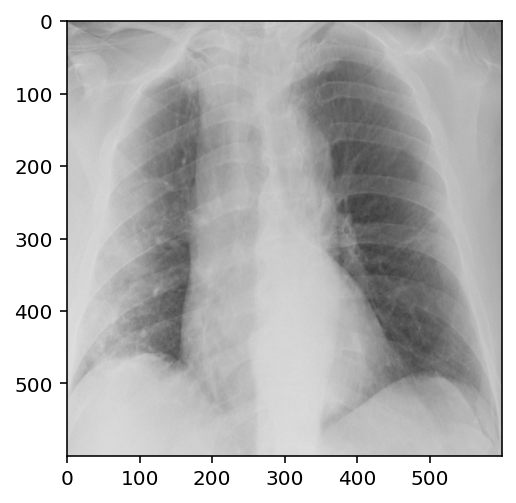

In [20]:
plt.imshow(a)